## Plot hexagon modulation align EC mean orientation across 4-8 folds

In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_style("darkgrid")

data = pd.read_csv( r'/mnt/workdir/DCM/result/Specificity_to_6/RSA/sub-hp_ROI-EC-L_amplitude-z.csv')

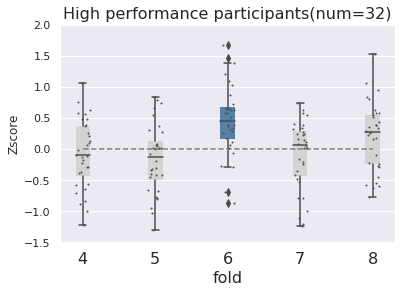

In [137]:
fig, ax = plt.subplots()
sns.boxplot(x='ifold', y="amplitude", data=data, width=.2,
            palette=["lightgray", "lightgray", "steelblue", "lightgray", "lightgray"],
            boxprops={'edgecolor':'None'},
            )
sns.stripplot(x='ifold', y="amplitude", data=data, size=2, color='.3', linewidth=0)
x = [0,1,2,3,4]
y = [0]*len(x)
plt.plot(x, y, linestyle='--', color='gray')
plt.ylim(-1.5, 2)
plt.xticks(size=16)
plt.xlabel('fold',size=16)
plt.ylabel('Zscore')

sub_num = len(set(data['sub_id']))
plt.title("High performance participants(num={})".format(sub_num),size=16)
plt.show()

In [135]:
from scipy.stats import ttest_1samp
ifold_p = []
for i in range(4,9):
    fold6_act = data.query(f'ifold=={i}')['amplitude'].to_list()
    _,p = ttest_1samp(fold6_act,0,alternative='greater')
    ifold_p.append(p)
    p = round(p,6)
    print('one sample t-test result of {}fold: pvalue={}'.format(i,p))

one sample t-test result of 4fold: pvalue=0.770097
one sample t-test result of 5fold: pvalue=0.941131
one sample t-test result of 6fold: pvalue=3.4e-05
one sample t-test result of 7fold: pvalue=0.826303
one sample t-test result of 8fold: pvalue=0.020299


In [114]:
from scipy.stats import ttest_rel

act1 = data.query(f'ifold==6')['amplitude'].to_list()
act2 = data.query(f'ifold==8')['amplitude'].to_list()
_,p = ttest_rel(act1,act2)
p = round(p,6)
print('pair t-test result: pvalue={}'.format(p))

pair t-test result: pvalue=0.961061
